# Introduction

The source code below, demonstrates the usage of CNN LeNet-5 architecture for two classes 1,2.

# Runtime req

In [32]:
!nvidia-smi

Fri Jul 21 02:10:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |   1515MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install appropriate run time and prepare the dataset.

In [ ]:
!pip install -q torch
!pip install -q matplotlib
!pip install -q visualkeras
!unzip -q "/content/drive/MyDrive/colab_notebooks/IITD-QML/EuroSAT_RGB.zip"

replace EuroSAT_RGB/Forest/Forest_864.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Configure runtime to make sure that the imports are working well.

In [ ]:
import sys
import numpy as np
import random
import torch
import glob
import os
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

sys.path.append('/content/drive/MyDrive/colab_notebooks/IITD-QML/')
dataset_root_path = '/content/EuroSAT_RGB'


Discover the root path for all the classes present in folder hierarchy.

# Classical CNN


In [ ]:
kernel_size = 3
stride = 1

model = Sequential()
model.add(Conv2D(16, kernel_size=kernel_size, strides=stride, activation='relu', padding='same', input_shape = (64,64,3)))
model.add(AveragePooling2D())
model.add(Conv2D(32, kernel_size=kernel_size, strides=stride, activation='relu', padding='valid'))
model.add(AveragePooling2D())
model.add(Conv2D(64, kernel_size=kernel_size, strides=stride, activation='relu', padding='valid'))
model.add(AveragePooling2D())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=SGD(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 average_pooling2d_3 (Averag  (None, 32, 32, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        4640      
                                                                 
 average_pooling2d_4 (Averag  (None, 15, 15, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 average_pooling2d_5 (Averag  (None, 6, 6, 64)        

In [ ]:
import glob
import os
import numpy as np
import random

class DatasetHandler:
    def __init__(self, ds_root_path):
        print ('Datahandler init -> ', ds_root_path)
        self.dataset_path = ds_root_path
        self.classes = glob.glob(os.path.join(ds_root_path, '*'))
        self.classes_dict = {}
        for c, i in zip(self.classes, range(len(self.classes))):
          self.classes_dict[c] = i

    def print_classes(self):
        print('Classes in the path: ')
        for i,c in enumerate(self.classes):
            print(i, ' ->', c)

    def load_paths_labels(self, root, classes):
        imgs_path = []
        imgs_label = []

        for clss in self.classes[:2]:
            for path in glob.glob(os.path.join(root, clss+'/*')):
              imgs_path.append(path)
              imgs_label.append(self.classes_dict[clss])

        dataset = list(zip(imgs_path, imgs_label))
        random.shuffle(dataset)
        paths, labels = zip(*dataset)
        return np.array(paths), np.array(labels)

    # Split the dataset into training and validation dataset
    def train_validation_split(self, images, labels, split_factor = 0.2):
        val_size = int(len(images)*split_factor)
        train_size = int(len(images) - val_size)
        return images[0:train_size], labels[0:train_size, ...], images[train_size:train_size+val_size], labels[train_size:train_size+val_size, ...]

    # Data genertor: given images paths and images labels yield a batch of images and labels
    def cnn_data_loader(self, imgs_path, imgs_label, batch_size = 16, img_shape = (64, 64, 3), n_classes = 2):
        # Initialize the vectors to be yield
        batch_in = np.zeros((batch_size, img_shape[0], img_shape[1], img_shape[2]))
        batch_out = np.zeros((batch_size, n_classes))
        # Repeat until the generator will be stopped
        while True:
            # Load a batch of images and labels
            for i in range(batch_size):
                # Select a random image and labels from the dataset
                index = random.randint(0, len(imgs_path)-1)
                # Fill the vectors with images and labels
                batch_in[i, ...] = plt.imread(imgs_path[index])/255.0
                l = np.zeros((n_classes))
                l[imgs_label[index]] = 1
                batch_out[i, ...] = l

            # Yield/Return the image and labeld vectors
            yield batch_in, batch_out


In [ ]:
handler = DatasetHandler(dataset_root_path)
imgs_path, imgs_label = handler.load_paths_labels(dataset_root_path, handler.classes[:2])
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Datahandler init ->  /content/EuroSAT_RGB
Dataset images: 5500 Dataset labels: 5500
Dataset sample -> /content/EuroSAT_RGB/Residential/Residential_1945.jpg 0


In [ ]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (4400,) Y_train shape: (4400,)
  X_val shape:  (1100,)   Y_val shape:  (1100,)


In [ ]:
def plotDataset(images, labels, classes, columns, rows):
    fig, axes = plt.subplots(nrows = rows, ncols = columns, figsize = (columns*4,rows*4))
    for x in range(columns):
        for y in range(rows):
            index = random.randint(0, len(images)-1)

            axes[y,x].imshow(plt.imread(images[index]))
            axes[y,x].set_title('Label: ' + str(labels[index]) +
                                '\n Class: ' + classes[labels[index]].split('/')[-1])
            axes[y,x].axis(False)

    plt.show()

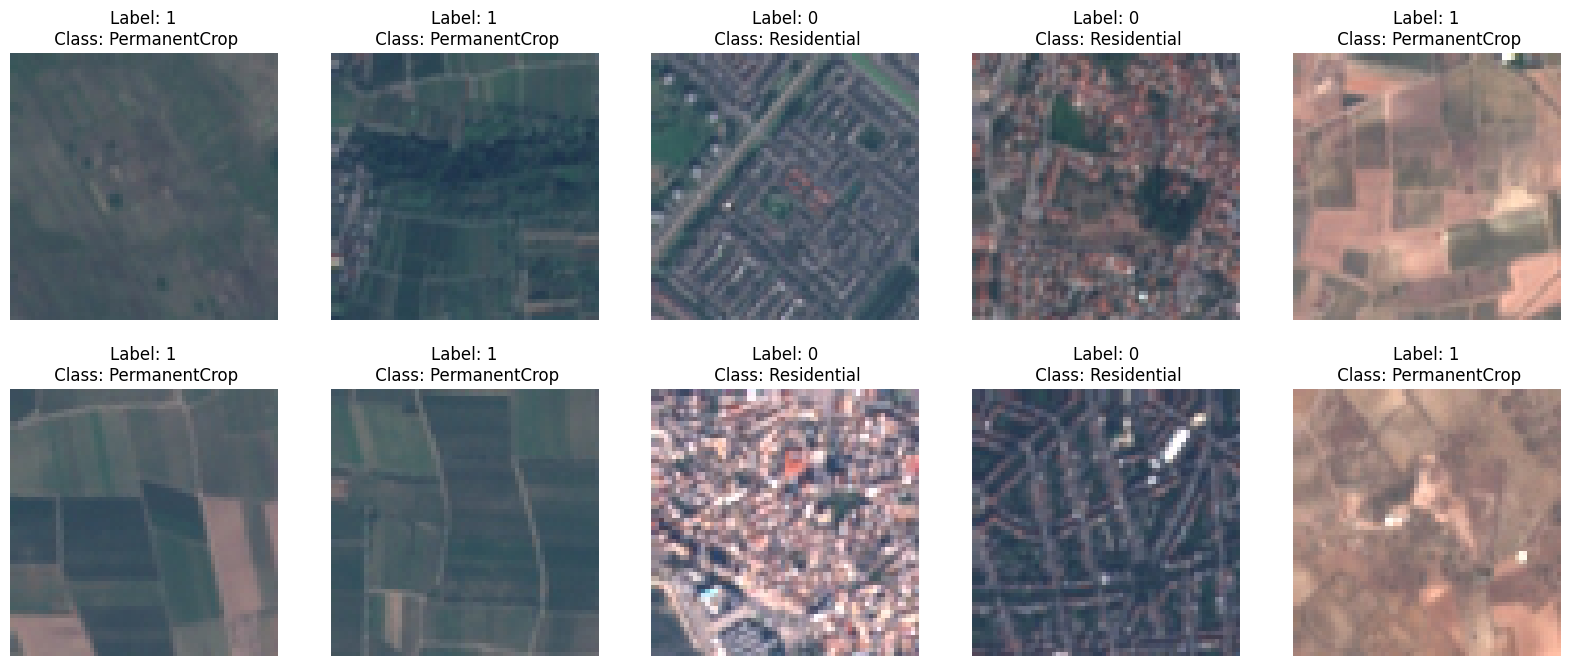

In [ ]:
plotDataset(train_imgs, train_labels, handler.classes, columns = 5, rows = 2)

In [ ]:
batch_size = 1
epochs = 100

train_gen = handler.cnn_data_loader(train_imgs, train_labels, batch_size=batch_size, img_shape=(64,64,3), n_classes=2)
val_gen = handler.cnn_data_loader(val_images, val_labels, batch_size=batch_size, img_shape=(64,64,3), n_classes=2)

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

history = model.fit(train_gen,
                            steps_per_epoch = len(train_labels)//batch_size,
                            epochs = epochs,
                            validation_data = val_gen,
                            validation_steps = len(val_labels)//batch_size,
                            callbacks = [es])

Epoch 1/100
4400/4400 [==============================] - 31s 6ms/step - loss: 0.6771 - accuracy: 0.5798 - val_loss: 0.6688 - val_accuracy: 0.7091
Epoch 2/100
4400/4400 [==============================] - 28s 6ms/step - loss: 0.6415 - accuracy: 0.7061 - val_loss: 0.6104 - val_accuracy: 0.7164
Epoch 3/100
4400/4400 [==============================] - 26s 6ms/step - loss: 0.5914 - accuracy: 0.7105 - val_loss: 0.6157 - val_accuracy: 0.6664
Epoch 4/100
4400/4400 [==============================] - 29s 6ms/step - loss: 0.5236 - accuracy: 0.7543 - val_loss: 0.4984 - val_accuracy: 0.7600
Epoch 5/100
4400/4400 [==============================] - 26s 6ms/step - loss: 0.4691 - accuracy: 0.7877 - val_loss: 0.4209 - val_accuracy: 0.8200
Epoch 6/100
4400/4400 [==============================] - 27s 6ms/step - loss: 0.4396 - accuracy: 0.8111 - val_loss: 0.4361 - val_accuracy: 0.8155
Epoch 7/100
4400/4400 [==============================] - 28s 6ms/step - loss: 0.4015 - accuracy: 0.8325 - val_loss: 0.3376 -

In [35]:
model.save(os.path.join('trained_models', 'CNN-binary-classification.h5'))

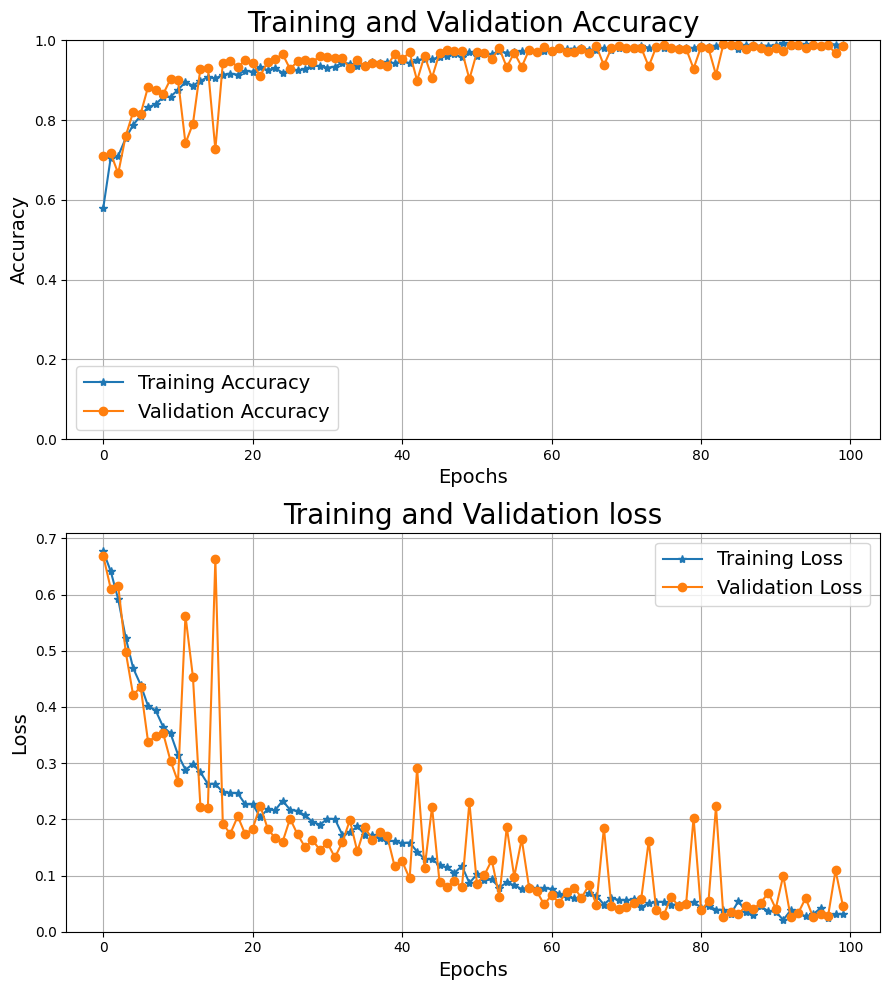

In [34]:
def plotCNNhistory(history):
    x = np.arange(0, len(history.history['accuracy']))

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 10))

    axes[0].plot(x, history.history['accuracy'], '-*')
    axes[0].plot(x, history.history['val_accuracy'], '-o')
    axes[0].legend(['Training Accuracy', 'Validation Accuracy'], fontsize = 14)
    axes[0].set_title('Training and Validation Accuracy', fontsize=20)
    axes[0].set_xlabel('Epochs', fontsize = 14)
    axes[0].set_ylabel('Accuracy', fontsize = 14)
    axes[0].set_ylim([0,1])
    axes[0].grid()

    axes[1].plot(x, history.history['loss'], '-*')
    axes[1].plot(x, history.history['val_loss'], '-o')
    axes[1].legend(['Training Loss', 'Validation Loss'], fontsize = 14)
    axes[1].set_title('Training and Validation loss', fontsize = 20)
    axes[1].set_xlabel('Epochs', fontsize = 14)
    axes[1].set_ylabel('Loss', fontsize = 14)
    axes[1].set_ylim([0,None])
    axes[1].grid()

    fig.tight_layout()
    plt.show()

plotCNNhistory(history)

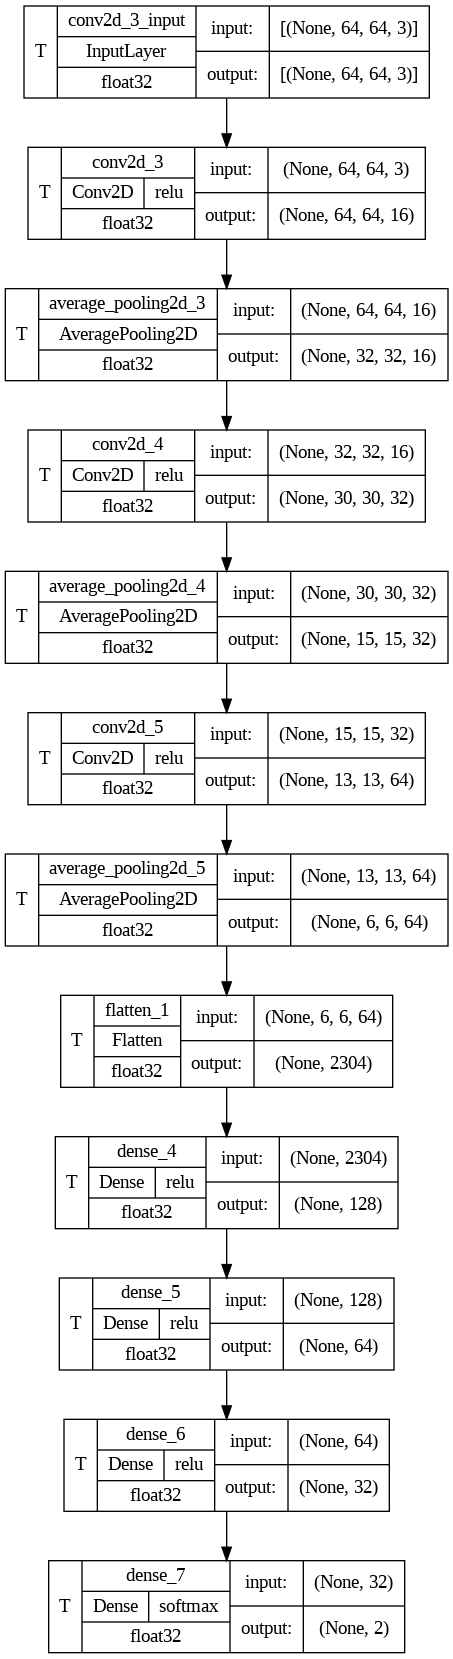

In [33]:
import keras
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True,show_dtype=True, show_layer_names=True, show_layer_activations=True, show_trainable=True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

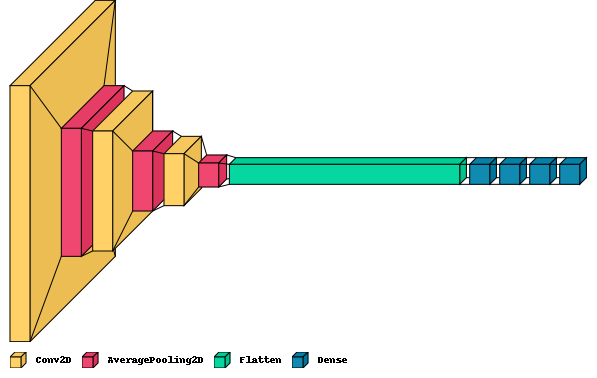

In [36]:
import visualkeras
visualkeras.layered_view(model, legend=True,)